$$
\newcommand{\bx}{\mathbf{x}}
\newcommand{\bv}{\mathbf{v}}
\newcommand{\by}{\mathbf{y}}
\newcommand{\bz}{\mathbf{z}}
\newcommand{\E}{\mathbb{E}}
\newcommand{\V}{\mathbb{V}}
\newcommand{\R}{\mathbb{R}}
\newcommand{\calN}{\mathcal{N}}
\newcommand{\tr}{\textrm{Tr}}
\newcommand{\expect}[1]{\langle {#1} \rangle}
$$

## 2D Mixture of Gaussians EM Demo

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import seaborn as sns

sns.set(style="white", color_codes=True)

### Prepare data

In [2]:
A = np.loadtxt("../data/faithful.csv", delimiter=",")
A -= np.mean(A, axis=0)
A /= np.std(A, axis=0)
data_labels = ('Eruption wait','Eruption length')

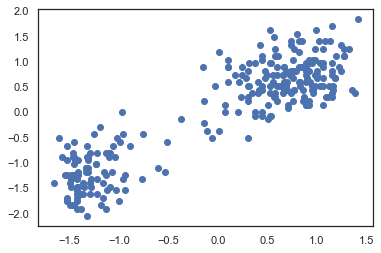

In [3]:
plt.scatter(A[:, 0], A[:, 1])
plt.show()

### Plotting helper functions

In [22]:
# plot_cov_ellipse was taken from here:
# http://www.nhsilbert.net/source/2014/06/bivariate-normal-ellipse-plotting-in-python/

def plot_cov_ellipse(cov, pos, volume=.5, ax=None, fc='none', ec=[0,0,0], a=1, lw=2):
    """
    Plots an ellipse enclosing *volume* based on the specified covariance
    matrix (*cov*) and location (*pos*). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        volume : The volume inside the ellipse; defaults to 0.5
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
    """

    from scipy.stats import chi2
    from matplotlib.patches import Ellipse

    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    kwrg = {'facecolor':fc, 'edgecolor':ec, 'alpha':a, 'linewidth':lw}

    # Width and height are "full" widths, not radius
    width, height = 2 * np.sqrt(chi2.ppf(volume,2)) * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwrg)

    ax.add_artist(ellip)
    

def plot_components(mu, Sigma, colours, *args, **kwargs):
    '''
    Plot ellipses for the bivariate normals with mean mu[i,:] and covariance Sigma[i,:,:]
    '''
    assert mu.shape[0] == Sigma.shape[0]
    assert mu.shape[1] == 2
    assert Sigma.shape[1] == 2
    assert Sigma.shape[2] == 2
    for i in range(mu.shape[0]):
        kwargs['ec'] = colours[i]
        plot_cov_ellipse(Sigma[i], mu[i], *args, **kwargs)

import matplotlib.colors as mcol

br_cmap = mcol.LinearSegmentedColormap.from_list("MyCmapName",["b","r"])

def plot_data(data, redness=None):
    if redness is not None:
        assert len(redness) == data.shape[1]
        assert all(_ >= 0 and _ <= 1 for _ in redness)
        c = redness
    else:
        c = 'g'
    plt.figure(figsize=(8,8))
    plt.scatter(data[:,0],data[:,1], marker='.', s=8, linewidths=2, c=c, cmap=br_cmap)
    plt.xlabel(data_labels[0])
    plt.ylabel(data_labels[1])
    plt.axis([-2, 2, -2, 2])

### EM optimisation

The expectation step consists of computing the following expectations:

\begin{align}
    r_{ik} &= \expect{\delta_{s_i=k}}_q \propto P(\bx_i \mid s_i = k, \theta) P(s_i = k \mid \theta) \\
    &= \frac{\pi_k \calN(\bx_i; \mu_k, \Sigma_k)}{\sum_{k'} \pi_{k'} \calN(\bx_i; \mu_{k'}, \Sigma_{k'})}
\end{align}

The maximisation step updates the parameters with above expectations as:

\begin{align}
    \pi_k &= \frac{\sum_{i}r_{ik}}{N} \\
    \mu_k &= \frac{1}{\sum_{i}r_{ik}}{\sum_i r_{ik}\bx_i} \\
    \Sigma_k &= \frac{1}{\sum_{i}r_{ik}}{\sum_i r_{ik} (\bx_i - \mu_k) (\bx_i - \mu_k)^T}
\end{align}

For implementational reference, we make explicit the structure of the np arrays holding 
the data, parameters, latents.

N: number of data points
D: dimensionality of the data
K: number of mixtures

A: N, D

mixings: K,
means: K, D
covariances: K, D, D

In [5]:
N, D = A.shape
K = 2

In [6]:
def initial_parameters(D, K):
    mixings = np.ones([K]) / K
    means = np.array([[-1,1],[1,-1]], dtype=np.float)
    covariances = np.concatenate([np.eye(D).reshape(1, D, D) for _ in range(K)], axis=0)
    
    return mixings, means, covariances

In [7]:
def normal_log_pdf(data, means, covariances):
    """
    Compute log pdf for N data points for K different normal distributions.
    
    Dimensionality of returned np arrays indicated.
    
    Arguments:
        data: N x D
        means: K x D
        covariances: K x D x D
    Returns:
        K x N
    """
    centered = -(means[:, None, :] - data)  # K x N x D
    outerproducts = centered[:, :, :, None] @ centered[:, :, None, :]  # K x N x D x D
    exponents = np.einsum('kij,knij->kn', np.linalg.inv(covariances), outerproducts) # K x N
    logdets = np.log(np.linalg.det(covariances))  # K
    log_probs = D * np.log(2 * np.pi) + logdets.reshape(-1, 1) + exponents
    log_probs *= -0.5
    
    return log_probs

In [8]:
def E(data, *old_params):
    mixings, means, covariances = old_params
    
    log_probs = normal_log_pdf(data, means, covariances)  # K x N
    probs = np.exp(log_probs)
    
    responsibilities = mixings[:, None] * probs  # K x N
    responsibilities /= np.sum(responsibilities, axis=0)

    return {'indicators': responsibilities}

In [9]:
def M(data, *old_params, **expectations):
    N, D = data.shape
    old_mixings, old_means, old_covariances = old_params
    responsibilities = expectations["indicators"]
    
    total_responsibilities = np.sum(responsibilities, axis=1)

    mixings = total_responsibilities / N
    means = responsibilities @ data / total_responsibilities[:, None]
    centered = -(means[:, None, :] - data)  # K x N x D
    outerproducts = centered[:, :, :, None] @ centered[:, :, None, :]  # K x N x D x D
    covariances = np.sum(responsibilities[..., None, None] * outerproducts, axis=1) / total_responsibilities[:, None, None]  # K x D x D
    return mixings, means, covariances

\begin{align}
    L(\theta) &= -\log \prod_i P(\bx_i; \theta) \\
    &= -\sum_i \log (\sum_k \pi_k \calN(\bx_i; \mu_k, \Sigma_k))
\end{align}

In [10]:
def neg_loglikelihood(data, *params):
    log_probs = normal_log_pdf(data, means, covariances)
    probs = np.exp(log_probs)
    
    responsibilities = mixings[:, None] * probs  # K x N
    
    return -np.sum(np.log(np.sum(responsibilities, axis=0)))

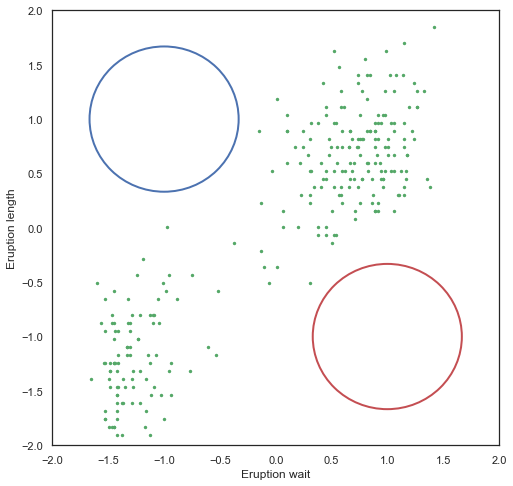

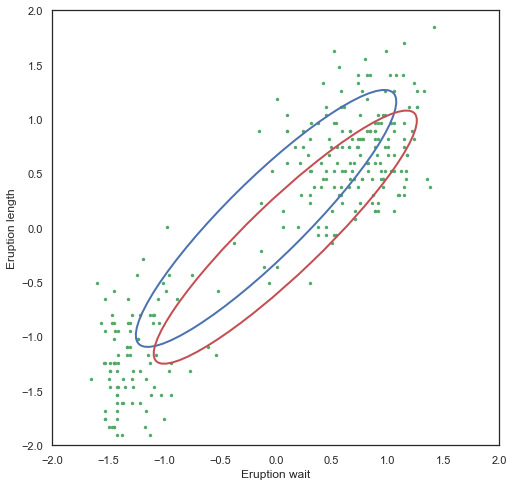

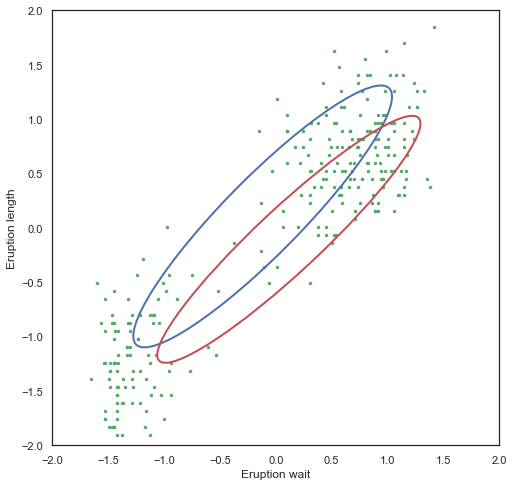

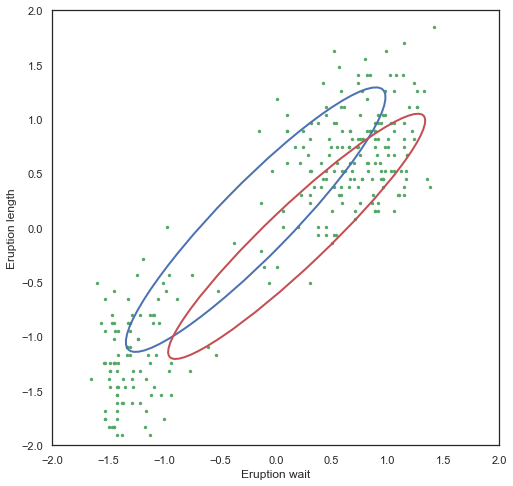

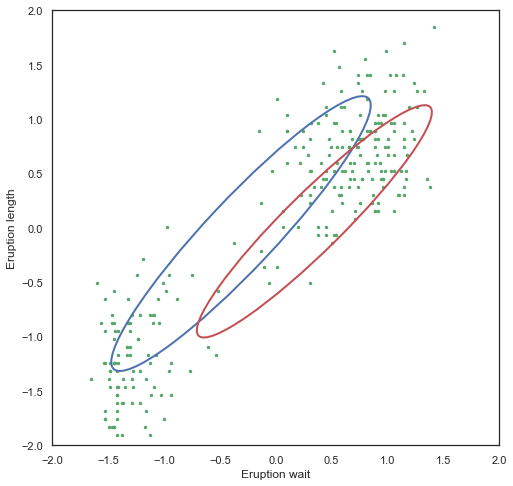

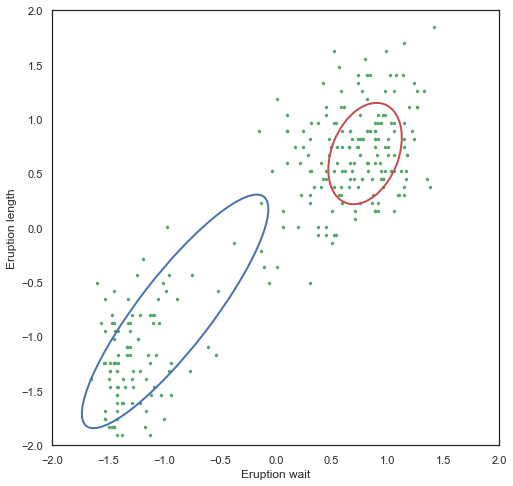

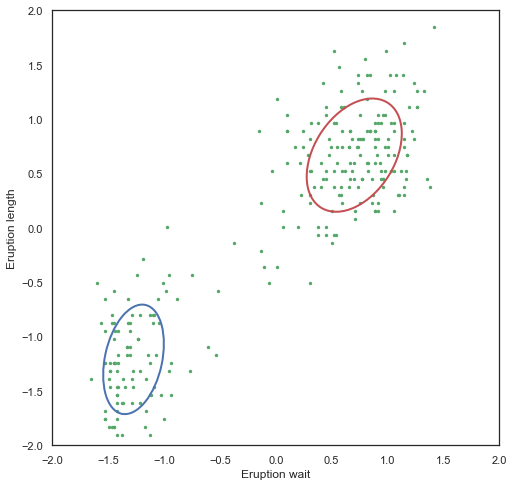

In [23]:
num_iters = 50

mixings, means, covariances = initial_parameters(D, K)
plot_data(A)
plot_components(means, covariances, ['b','r'], 0.2)
plt.show()

mixings_arr = []
neg_lls = []

for i in range(num_iters + 1):
    expectations = E(A, mixings, means, covariances)
    mixings, means, covariances = M(A, mixings, means, covariances, **expectations)
    mixings_arr.append(mixings)
    neg_lls.append(neg_loglikelihood(A, mixings, means, covariances))
    if i%10==0:
        plot_data(A)
        plot_components(means, covariances, ['b','r'], 0.5)
        plt.show()

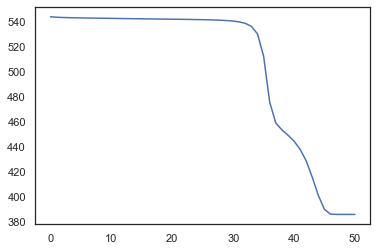

In [12]:
plt.plot(np.arange(num_iters+1), neg_lls)
plt.show()